# 1. Setting up Paths


In [1]:
WORKSPACE_PATH = 'Tensorflow/workspace'
SCRIPTS_PATH = 'Tensorflow/scripts'
APIMODEL_PATH = 'Tensorflow/models'
ANNOTATION_PATH = WORKSPACE_PATH+'/annotations'
IMAGE_PATH = WORKSPACE_PATH+'/images'
MODEL_PATH = WORKSPACE_PATH+'/models'
NEW_MODEL_PATH = WORKSPACE_PATH+'/new-model'
CONFIG_PATH = MODEL_PATH+'/my_ssd_mobnet/pipeline.config'
CHECKPOINT_PATH = MODEL_PATH+'/my_ssd_mobnet/'

# 2. Pre-processing of the images

In [2]:
from keras.layers import Input, Lambda, Dense, Flatten,Dropout
from keras.models import Model
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
import pandas as pd
import os

In [3]:
TRAIN_PATH=IMAGE_PATH+"/train"
TEST_PATH=IMAGE_PATH+"/test"
VAL_PATH=IMAGE_PATH+"/val"

In [6]:
import cv2

x_train=[]

sub_path=TRAIN_PATH+"/"

for img in os.listdir(sub_path):

    IMAGE_PATH=sub_path+img

    img_arr=cv2.imread(IMAGE_PATH)

    x_train.append(img_arr)

x_test=[]

sub_path=TEST_PATH+"/"

for img in os.listdir(sub_path):

    IMAGE_PATH=sub_path+img

    img_arr=cv2.imread(IMAGE_PATH)

    x_test.append(img_arr)

x_val=[]

sub_path=VAL_PATH+"/"

for img in os.listdir(sub_path):

    IMAGE_PATH=sub_path+img

    img_arr=cv2.imread(IMAGE_PATH)

    x_val.append(img_arr)

In [9]:
import numpy as np

train_x=np.array(x_train)
test_x=np.array(x_test)
val_x=np.array(x_val)

train_x=train_x/255.0
test_x=test_x/255.0
val_x=val_x/255.0

In [13]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(TRAIN_PATH,
                                                 target_size = (128, 128),
                                                 batch_size = 32,
                                                 class_mode = 'sparse')
test_set = test_datagen.flow_from_directory(TEST_PATH,
                                            target_size = (128, 128),
                                            batch_size = 32,
                                            class_mode = 'sparse')
val_set = val_datagen.flow_from_directory(VAL_PATH,
                                            target_size = (128, 128),
                                            batch_size = 32,
                                            class_mode = 'sparse')

Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.


In [27]:
train_y=training_set.classes
test_y=test_set.classes
val_y=val_set.classes

In [28]:
training_set.class_indices

train_y.shape,test_y.shape,val_y.shape

((0,), (0,), (0,))

In [31]:
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input

vgg = VGG19(input_shape = (128,128,3), weights='imagenet', include_top=False)

ValueError: The input must have 3 channels; Received `input_shape=(128, 128, 1)`

In [12]:
#do not train the pre-trained layers of VGG-19
for layer in vgg.layers:
    layer.trainable = False

In [13]:
x = Flatten()(vgg.output)

#adding output layer.Softmax classifier is used as it is multi-class classification
prediction = Dense(3, activation='softmax')(x)

model = Model(inputs=vgg.input, outputs=prediction)
print(prediction)

KerasTensor(type_spec=TensorSpec(shape=(None, 3), dtype=tf.float32, name=None), name='dense/Softmax:0', description="created by layer 'dense'")


In [14]:
# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [15]:
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

In [16]:
from keras.callbacks import EarlyStopping
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)
#Early stopping to avoid overfitting of model

In [17]:
# fit the model
history = model.fit(
  train_x,
  train_y,
  validation_data=(val_x,val_y),
  epochs=10,
  callbacks=[early_stop],
  batch_size=32,shuffle=True)

Epoch 1/10
44/44 [==============================] - 14s 178ms/step - loss: 0.5431 - accuracy: 0.8294 - val_loss: 0.0630 - val_accuracy: 0.9857
Epoch 2/10
44/44 [==============================] - 5s 111ms/step - loss: 0.0401 - accuracy: 0.9914 - val_loss: 0.0376 - val_accuracy: 0.9943
Epoch 3/10
44/44 [==============================] - 5s 113ms/step - loss: 0.0230 - accuracy: 0.9993 - val_loss: 0.0425 - val_accuracy: 0.9886
Epoch 4/10
44/44 [==============================] - 5s 112ms/step - loss: 0.0149 - accuracy: 1.0000 - val_loss: 0.0290 - val_accuracy: 0.9943
Epoch 5/10
44/44 [==============================] - 5s 113ms/step - loss: 0.0098 - accuracy: 1.0000 - val_loss: 0.0247 - val_accuracy: 0.9971
Epoch 6/10
44/44 [==============================] - 5s 113ms/step - loss: 0.0074 - accuracy: 1.0000 - val_loss: 0.0233 - val_accuracy: 0.9971
Epoch 7/10
44/44 [==============================] - 5s 114ms/step - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.0213 - val_accuracy: 0.9971
Epoch

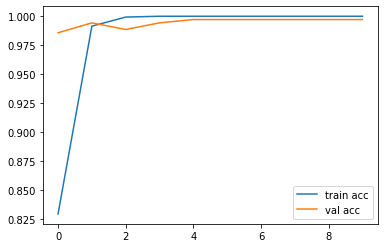

In [18]:
# accuracies

plt.plot(history.history['accuracy'], label='train acc')

plt.plot(history.history['val_accuracy'], label='val acc')

plt.legend()

plt.savefig('vgg-acc-fd-1.png')

plt.show()

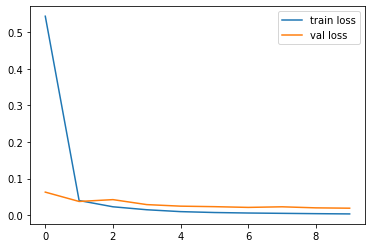

In [19]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.savefig('vgg-loss-fd-1.png')
plt.show()

In [20]:
model.evaluate(test_x,test_y,batch_size=32)

14/14 [==============================] - 2s 169ms/step - loss: 0.0167 - accuracy: 1.0000


[0.016677411273121834, 1.0]

In [21]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import numpy as np

In [22]:
#predict
y_pred=model.predict(test_x)
y_pred=np.argmax(y_pred,axis=1)

In [23]:
#get classification report
print(classification_report(y_pred,test_y))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       142
           1       1.00      1.00      1.00       145
           2       1.00      1.00      1.00       150

    accuracy                           1.00       437
   macro avg       1.00      1.00      1.00       437
weighted avg       1.00      1.00      1.00       437



In [24]:
print(confusion_matrix(y_pred,test_y))
print(prediction)

[[142   0   0]
 [  0 145   0]
 [  0   0 150]]
KerasTensor(type_spec=TensorSpec(shape=(None, 3), dtype=tf.float32, name=None), name='dense/Softmax:0', description="created by layer 'dense'")


In [25]:
model.save("vgg-FD-final.h5")